In [1]:
using Revise
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, Statistics, Random, LinearAlgebra, TensorTrains, SparseArrays
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using TensorTrains: summary_compact
using SparseArrays
using Plots
include("../fourier_tensor_train.jl")
includet("../bp_fourier.jl");

In [2]:
seed = 1
rng = MersenneTwister(seed)

T = 25
k = 8

β = 1.0
J = 1
h = 0.0
m⁰ = 0.2
K = 40

svd_trunc=TruncBond(4)
;

In [3]:
w = fill(HomogeneousGlauberFactor(float(J), h, β), T+1)
w_fourier = fill(IntegerGlauberFactor(fill(J,k), h, β), T+1)
ϕ = [t == 0 ? [(1-m⁰)/2, (1+m⁰)/2] : ones(2) for t in 0:T]

bp = mpbp_infinite_graph(k, w, 2, ϕ)
bp_fourier = mpbp_infinite_graph(k, w_fourier, 2, ϕ, elem_type=ComplexF64)
;

In [4]:
iters, cb = iterate!(bp, maxiter=100; svd_trunc);

Running MPBP: iter 2    Time: 0:01:07

Running MPBP: iter 4    Time: 0:01:08

Running MPBP: iter 5    Time: 0:01:08

Running MPBP: iter 6    Time: 0:01:09

Running MPBP: iter 7    Time: 0:01:09

Running MPBP: iter 8    Time: 0:01:09

Running MPBP: iter 9    Time: 0:01:10

Running MPBP: iter 10    Time: 0:01:10

Running MPBP: iter 11    Time: 0:01:10

Running MPBP: iter 12    Time: 0:01:11

Running MPBP: iter 13    Time: 0:01:11

Running MPBP: iter 14    Time: 0:01:11

Running MPBP: iter 15    Time: 0:01:12

Running MPBP: iter 16    Time: 0:01:12

Running MPBP: iter 17    Time: 0:01:12

Running MPBP: iter 18    Time: 0:01:12

Running MPBP: iter 19    Time: 0:01:13

Running MPBP: iter 20    Time: 0:01:13

Running MPBP: iter 21    Time: 0:01:13

Running MPBP: iter 22    Time: 0:01:14

Running MPBP: iter 23    Time: 0:01:14

Running MPBP: iter 24    Time: 0:01:14

Running MPBP: iter 25    Time: 0:01:15

Running MPBP: iter 26    Time: 0:01:15

Running MPBP: iter 27    Time: 0:01:15

Running

In [5]:
iters, cb_fourier = iterate_fourier!(bp_fourier,K, maxiter=100, σ=1/100; svd_trunc, tol=1e-6);

Running MPBP: iter 2    Time: 0:00:39

Running MPBP: iter 3    Time: 0:00:45

Running MPBP: iter 4    Time: 0:00:50

Running MPBP: iter 5    Time: 0:00:56

Running MPBP: iter 6    Time: 0:01:02

Running MPBP: iter 7    Time: 0:01:07

Running MPBP: iter 8    Time: 0:01:12

Running MPBP: iter 9    Time: 0:01:18

Running MPBP: iter 10    Time: 0:01:23

Running MPBP: iter 11    Time: 0:01:29

Running MPBP: iter 12    Time: 0:01:35

Running MPBP: iter 13    Time: 0:01:40

Running MPBP: iter 14    Time: 0:01:46

Running MPBP: iter 15    Time: 0:01:52

Running MPBP: iter 16    Time: 0:01:57

Running MPBP: iter 17    Time: 0:02:03

Running MPBP: iter 18    Time: 0:02:09

Running MPBP: iter 19    Time: 0:02:14

Running MPBP: iter 20    Time: 0:02:21

Running MPBP: iter 21    Time: 0:02:27

Running MPBP: iter 22    Time: 0:02:32

Running MPBP: iter 23    Time: 0:02:38

Running MPBP: iter 24    Time: 0:02:44

Running MPBP: iter 25    Time: 0:02:49

Running MPBP: iter 26    Time: 0:02:55

Running 

In [6]:
potts2spin(x, i; q=2) = (x-1)/(q-1)*2 - 1

m = only(means(potts2spin, bp))
m_fourier = only(real.(means(potts2spin, bp_fourier)))
;

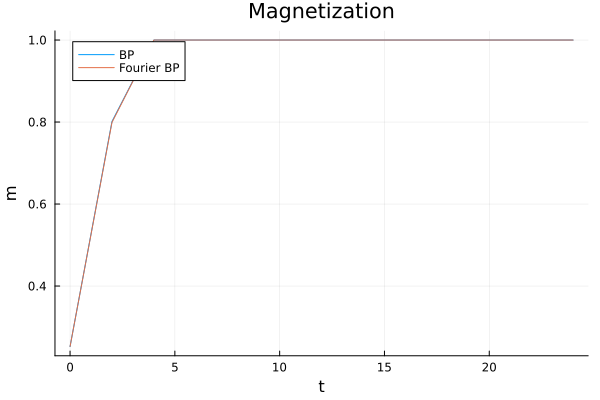

In [7]:
plot(0:2:T, m[1:2:end], label="BP", xlabel="t", ylabel="m", title="Magnetization", legend=:topleft)
plot!(0:2:T, m_fourier[1:2:end], label="Fourier BP")

In [8]:
er_μ = []
ptr = []
for e in edges(bp.g)
    μ_marg = marginalize(bp.μ[idx(e)])
    margs = marginals(μ_marg)
    μ_fourier_marg = marginalize(bp_fourier.μ[idx(e)])
    margs_fourier = marginals(μ_fourier_marg)
    for t in 1:T+1
        marg = margs[t]
        marg_fourier = margs_fourier[t]
        push!(er_μ, abs(marg_fourier[1]-marg[1]))
        push!(ptr, (e, t))
    end
end

display(maximum(er_μ))
display(ptr[argmax(er_μ)])

0.9999926448429746

(Indexed Edge 1 => 1 with index 1, 10)

In [9]:
er_b = []
ptr = []
for i in vertices(bp.g)
    margs = marginals(bp.b[i])
    margs_fourier = marginals(bp_fourier.b[i])
    for t in 1:T+1
        marg = margs[t]
        marg_fourier = margs_fourier[t]
        ind = argmax(abs.(marg))
        push!(er_b, abs(marg_fourier[ind]-marg[ind]))
        push!(ptr, (i, t))
    end
end

display(maximum(er_b))
display(ptr[argmax(er_b)])

0.9999994278199007

(1, 10)